In [1]:
from factor_transducer import *
import sentencepiece as spm
import k2
from tokenizer import *

## Previous

In [2]:
sp_model_path = "/exp/rhuang/meta/audio/examples/asr/librispeech_conformer_ctc/spm_unigram_1023.model"
sp = spm.SentencePieceProcessor(model_file=str(sp_model_path))

token2id = {sp.id_to_piece(i): i for i in range(sp.vocab_size())}
id2token = {v: k for k, v in token2id.items()}

del token2id[id2token[0]]
token2id["<eps>"] = 0
id2token[0] = "<eps>"

word_start_symbols = [i for i in range(sp.vocab_size()) if sp.id_to_piece(i).startswith('▁')]

In [3]:
text = "pen apple aaaz"
text_encoded = sp.encode(text, out_type=int)

# text_encoded = [24, 102, 70]
# text_encoded = [49, 11, 7, 161, 24]
# text_encoded = [49, 11, 7, 49, 49, 161, 24]

print(text_encoded)
print([sp.id_to_piece(p) for p in text_encoded])

[340, 15, 7, 208, 44, 7, 38, 38, 186]
['▁pe', 'n', '▁a', 'pp', 'le', '▁a', 'a', 'a', 'z']


In [4]:
# fst = make_factor_transducer1(text_encoded, return_str=False, blank_penalty=0)
# fst = make_factor_transducer2(text_encoded, return_str=False, blank_penalty=0)
fst = make_factor_transducer3(text_encoded, word_start_symbols, return_str=False, blank_penalty=0)

fst.labels_sym = k2.SymbolTable.from_str("\n".join([f"{k} {v}" for k, v in token2id.items()]))
fst.aux_labels_sym = fst.labels_sym

In [21]:
# fst = make_factor_transducer4(text_encoded, word_start_symbols, return_str=False, blank_penalty=0)
fst = make_factor_transducer4_skip(text_encoded, word_start_symbols, return_str=False, blank_penalty=0)

fst.labels_sym = k2.SymbolTable.from_str("\n".join([f"{k} {v}" for k, v in token2id.items()]))
fst.aux_labels_sym = k2.SymbolTable.from_str("\n".join([f"{v} {k+1}" for k, v in enumerate(text.split() + [None])]))

Num nodes: 21
Num arcs:  60


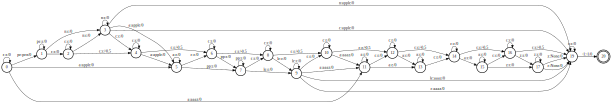

In [23]:
print(f"Num nodes: {fst.shape[0]}")
print(f"Num arcs:  {fst.num_arcs}")
k2.to_dot(fst)

[340, 15, 7, 208, 44, 7, 38, 38, 186]
Num nodes: 20
Num arcs:  46


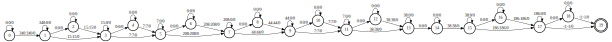

In [10]:
fst_graph = k2.ctc_graph([flatten_list(text_encoded)], modified=False, device='cpu')[0]
print(flatten_list(text_encoded))
print(f"Num nodes: {fst_graph.shape[0]}")
print(f"Num arcs:  {fst_graph.num_arcs}")
k2.to_dot(fst_graph)

In [9]:
print(k2.to_str_simple(fst_graph))

0 0 0 0 0
0 1 340 340 0
1 2 0 0 0
1 1 340 0 0
1 3 15 15 0
2 2 0 0 0
2 3 15 15 0
3 4 0 0 0
3 3 15 0 0
3 5 7 7 0
4 4 0 0 0
4 5 7 7 0
5 6 0 0 0
5 5 7 0 0
5 7 208 208 0
6 6 0 0 0
6 7 208 208 0
7 8 0 0 0
7 7 208 0 0
7 9 44 44 0
8 8 0 0 0
8 9 44 44 0
9 10 0 0 0
9 9 44 0 0
9 11 7 7 0
10 10 0 0 0
10 11 7 7 0
11 12 0 0 0
11 11 7 0 0
11 13 38 38 0
12 12 0 0 0
12 13 38 38 0
13 14 0 0 0
13 13 38 0 0
14 14 0 0 0
14 15 38 38 0
15 16 0 0 0
15 15 38 0 0
15 17 186 186 0
16 16 0 0 0
16 17 186 186 0
17 18 0 0 0
17 17 186 0 0
17 19 -1 -1 0
18 18 0 0 0
18 19 -1 -1 0
19



## Now

In [2]:
text = "pen apple aaaz"

# tokenizer = EnglishPhonemeTokenizer()
# text_encoded = tokenizer.encode(text, out_type=int)

sp_model_path = "/exp/rhuang/meta/audio/examples/asr/librispeech_conformer_ctc/spm_unigram_1023.model"
sp_model = spm.SentencePieceProcessor(model_file=str(sp_model_path))
tokenizer = EnglishBPETokenizer(
    sp_model=sp_model,
    blk_token="<s>",  # You have to make sure these tokens are in the sp model 
    unk_token="<unk>",
)
text_encoded = tokenizer.encode(text, out_type=int)

print(text_encoded)
print(tokenizer.decode(text_encoded))

[[340, 15], [7, 208, 44], [7, 38, 38, 186]]
[['▁pe', 'n'], ['▁a', 'pp', 'le'], ['▁a', 'a', 'a', 'z']]


In [3]:
# fst = make_ctc_graph(text_encoded)
fst = make_factor_transducer_basic(text_encoded)

fst.labels_sym = k2.SymbolTable.from_str("\n".join([f"{k} {v}" for k, v in tokenizer.token2id.items()]))
fst.aux_labels_sym = fst.labels_sym

Num nodes: 20
Num arcs:  70


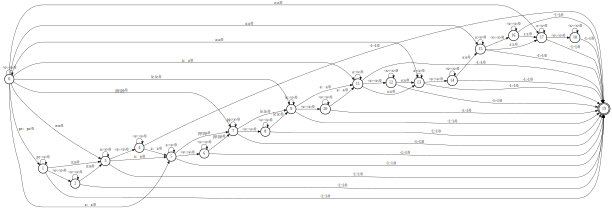

In [4]:
print(f"Num nodes: {fst.shape[0]}")
print(f"Num arcs:  {fst.num_arcs}")
k2.to_dot(fst)

In [7]:
def test_make_ctc_graph(text="pen apple aaaz"):
    sp_model_path = "/exp/rhuang/meta/audio/examples/asr/librispeech_conformer_ctc/spm_unigram_1023.model"
    sp_model = spm.SentencePieceProcessor(model_file=str(sp_model_path))
    
    tokenizer = EnglishBPETokenizer(
        sp_model=sp_model,
        blk_token="<s>",  # You have to make sure these tokens are in the sp model 
        unk_token="<unk>",
    )
    text_encoded1 = tokenizer.encode(text, out_type=int)
    # text_encoded1_check = tokenizer.decode(text_encoded)
    
    text_encoded2 = sp_model.encode(text, out_type=int)
    # text_encoded2_check = [sp.id_to_piece(p) for p in text_encoded2]

    fst_graph1 = make_ctc_graph(text_encoded1)
    # print(f"Num nodes 1: {fst_graph1.shape[0]}")
    # print(f"Num arcs 1:  {fst_graph1.num_arcs}")
    # k2.to_dot(fst_graph1)

    fst_graph2 = k2.ctc_graph([text_encoded2], modified=False, device='cpu')[0]
    # print(f"Num nodes 2: {fst_graph2.shape[0]}")
    # print(f"Num arcs 2:  {fst_graph2.num_arcs}")
    # k2.to_dot(fst_graph2)

    s1 = k2.to_str_simple(k2.arc_sort(fst_graph1))
    s2 = k2.to_str_simple(k2.arc_sort(fst_graph2))

    assert s1 == s2
    print("Sucessful!")
    return s1, s2

s1, s2 = test_make_ctc_graph()

Sucessful!


In [2]:
def test_make_factor_transducer1(text="pen apple aaaz"):
    sp_model_path = "/exp/rhuang/meta/audio/examples/asr/librispeech_conformer_ctc/spm_unigram_1023.model"
    sp_model = spm.SentencePieceProcessor(model_file=str(sp_model_path))
    
    tokenizer = EnglishBPETokenizer(
        sp_model=sp_model,
        blk_token="<s>",  # You have to make sure these tokens are in the sp model 
        unk_token="<unk>",
    )
    text_encoded1 = tokenizer.encode(text, out_type=int)
    # text_encoded1_check = tokenizer.decode(text_encoded)
    
    text_encoded2 = sp_model.encode(text, out_type=int)
    # text_encoded2_check = [sp.id_to_piece(p) for p in text_encoded2]

    fst_graph1 = make_factor_transducer_basic(text_encoded1, return_str=False, blank_penalty=0)
    # print(f"Num nodes 1: {fst_graph1.shape[0]}")
    # print(f"Num arcs 1:  {fst_graph1.num_arcs}")
    # k2.to_dot(fst_graph1)

    fst_graph2 = make_factor_transducer1(text_encoded2, return_str=False, blank_penalty=0)
    # print(f"Num nodes 2: {fst_graph2.shape[0]}")
    # print(f"Num arcs 2:  {fst_graph2.num_arcs}")
    # k2.to_dot(fst_graph2)

    s1 = k2.to_str_simple(k2.arc_sort(fst_graph1))
    s2 = k2.to_str_simple(k2.arc_sort(fst_graph2))

    assert s1 == s2
    print("Sucessful!")
    return s1, s2

s1, s2 = test_make_factor_transducer1()

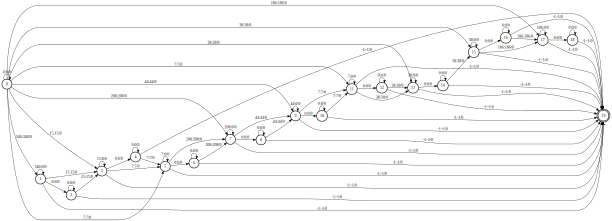

In [4]:
k2.to_dot(k2.Fsa.from_str(s1, acceptor=False))

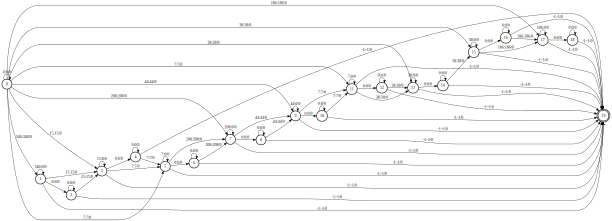

In [5]:
k2.to_dot(k2.Fsa.from_str(s2, acceptor=False))